In [1]:
import pandas as pd
import datetime as dt

In [2]:
aapl_text = pd.read_csv('../data/cleaned_AAPL_NEWS.csv')
aapl_finance = pd.read_csv('../data/AAPL_FULL_FINANCIAL.csv')


aapl_text['date'] = pd.to_datetime(aapl_text['date'], errors='coerce', utc=True)
aapl_finance['Date'] = pd.to_datetime(aapl_finance['Date'], errors='coerce', utc=True)

# Check the data types to ensure they were properly converted
print(aapl_text['date'].dtype)  # Should be datetime64[ns, UTC]
print(aapl_finance['Date'].dtype)  # Should be datetime64[ns, UTC]

datetime64[ns, UTC]
datetime64[ns, UTC]


In [3]:
aapl_text['Date'] = aapl_text['date'].dt.date
aapl_finance['Date'] = aapl_finance['Date'].dt.date

aapl_text.drop('date',axis=1, inplace=True)


In [4]:
aapl_df = pd.merge(aapl_finance, aapl_text, on='Date', how='left')
# print(aapl_df.columns)
aapl_df.drop('Unnamed: 0_x', axis = 1, inplace=True)
aapl_df.drop('Unnamed: 0_y', axis = 1, inplace=True)

print(aapl_df.head(40))

          Date      Close  Label     SMA_20     EMA_20      MACD  Signal_Line  \
0   2019-11-11  63.549580      0        NaN  63.549580  0.000000     0.000000   
1   2019-11-12  63.491405      1        NaN  63.544039 -0.004641    -0.000928   
2   2019-11-13  64.099770     -1        NaN  63.596966  0.040307     0.007319   
3   2019-11-14  63.656223      1        NaN  63.602609  0.039680     0.013791   
4   2019-11-15  64.412422      0        NaN  63.679735  0.099061     0.030845   
5   2019-11-18  64.737206     -1        NaN  63.780446  0.170363     0.058749   
6   2019-11-19  64.540878      0        NaN  63.852868  0.208625     0.088724   
7   2019-11-20  63.789539      0        NaN  63.846837  0.176288     0.106237   
8   2019-11-21  63.503529      0        NaN  63.814141  0.126128     0.110215   
9   2019-11-22  63.447792      1        NaN  63.779250  0.080946     0.104361   
10  2019-11-25  64.560272     -1        NaN  63.853633  0.133369     0.110163   
11  2019-11-26  64.056145   

In [5]:
print(aapl_df.columns)

Index(['Date', 'Close', 'Label', 'SMA_20', 'EMA_20', 'MACD', 'Signal_Line',
       'High_20', 'Low_20', 'Fib_23.6', 'Fib_38.2', 'Fib_61.8', '%K', '%D',
       'BB_Mid', 'BB_Upper', 'BB_Lower', 'RSI', 'Std_Dev_20', 'top_5_titles'],
      dtype='object')


In [6]:
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import string

/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Initialize VADER Sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Initialize HuggingFace sentiment analysis model
transformer_analyzer = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [8]:
def textblob_sentiment(text):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Neutral sentiment for missing text
    return TextBlob(text).sentiment.polarity

In [ ]:
def vader_sentiment(text):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Missing text has neutral sentiment
    return vader_analyzer.polarity_scores(text)['compound']

In [ ]:
def bow_sentiment(text, vectorizer=None):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Missing text has neutral sentiment
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words='english')
        vectorizer.fit([text])  # Fit on single sentence
    word_vector = vectorizer.transform([text]).toarray()
    return word_vector.mean()  # Using the mean of the feature vector as a basic sentiment score

In [11]:
def transformer_sentiment(text):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Neutral sentiment for missing text
    result = transformer_analyzer(text)
    return 1 if result[0]['label'] == 'POSITIVE' else -1

In [12]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        return text
    return '' # Replace NaN or non-strings with 'missing'

In [13]:
def train_lstm(X_train, y_train, X_test, y_test, input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    return accuracy

In [14]:
aapl_df['cleaned_text'] = aapl_df['top_5_titles'].apply(preprocess_text)

In [15]:
sentiment_methods = {
    'textblob': aapl_df['cleaned_text'].apply(textblob_sentiment),
    'vader': aapl_df['cleaned_text'].apply(vader_sentiment),
    'bow': aapl_df['cleaned_text'].apply(lambda x: bow_sentiment(x)),
    'transformer': aapl_df['cleaned_text'].apply(transformer_sentiment)
}

In [16]:
datasets = {}
for method, sentiment in sentiment_methods.items():
    aapl_df_temp = aapl_df.copy()
    aapl_df_temp[method + '_sentiment'] = sentiment
    datasets[method] = aapl_df_temp


In [17]:
results = {}
for method, dataset in datasets.items():
    # Split the dataset into features (X) and target (y)
    X = dataset[['Close', 'SMA_20', 'EMA_20', 'MACD', 'Signal_Line',
       'High_20', 'Low_20', 'Fib_23.6', 'Fib_38.2', 'Fib_61.8', '%K', '%D',
       'BB_Mid', 'BB_Upper', 'BB_Lower', 'RSI', 'Std_Dev_20', method + '_sentiment']]  # Assume 'price' and 'indicator' are numeric features
    y = dataset['Label']  # Replace with your target column

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the data (if necessary)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input for LSTM
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Train the LSTM model and get the accuracy
    accuracy = train_lstm(X_train_scaled, y_train, X_test_scaled, y_test, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
    results[method] = accuracy
    print(f"Accuracy for {method}: {accuracy}")

# Determine the best sentiment analysis method
best_method = max(results, key=results.get)
print(f"The optimal sentiment analysis methodology is: {best_method}")

Epoch 1/5


/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4767 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4527 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4767 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4927 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4995 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4625 - loss: nan
Accuracy for textblob: 0.4682539701461792
Epoch 1/5


/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4842 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5081 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4712 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4969 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.4625 - loss: nan
Accuracy for vader: 0.4682539701461792
Epoch 1/5


/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4824 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5111 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5074 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4826 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4982 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.4625 - loss: nan
Accuracy for bow: 0.4682539701461792
Epoch 1/5


/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4567 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5007 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4776 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5019 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4966 - loss: nan - val_accuracy: 0.4683 - val_loss: nan
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4625 - loss: nan
Accuracy for transformer: 0.4682539701461792
The optimal sentiment analysis methodology is: textblob


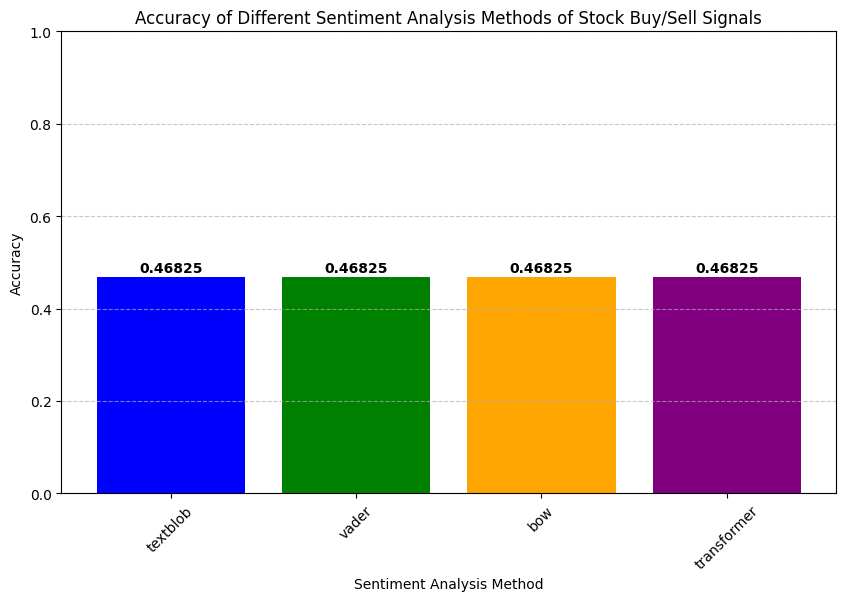

In [21]:
import matplotlib.pyplot as plt

# Prepare data for plotting
methods = list(results.keys())
accuracies = list(results.values())

# Plotting the accuracies as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel("Sentiment Analysis Method")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Sentiment Analysis Methods of Stock Buy/Sell Signals")
plt.ylim(0, 1)  # Assuming accuracy ranges from 0 to 1
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with accuracy values
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center', fontweight='bold')

plt.show()
